In [1]:
import scanpy as sc
import scanpy.external as sce
import os,sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker

In [2]:
# add the utility function folder to PATH
import sys
sys.path.append(os.path.abspath("utility_functions_190403_12h24/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.9.19


In [21]:
#import matplotlib as mpl
plt.rc('font',family='Arial')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [19]:
import warnings
warnings.filterwarnings( "ignore")

In [3]:
# Import adata

In [4]:
adata = sc.read_h5ad('AML/data/AML_prec_only_206_2167x2000_250123_12h07.h5ad')    

In [5]:

adata.X.sum(axis=1)

matrix([[ 459.4988  ],
        [ 337.34085 ],
        [-479.11826 ],
        ...,
        [-292.71057 ],
        [ 257.36533 ],
        [ -41.697548]], dtype=float32)

In [7]:
adata_raw = sc.read_h5ad('AML/data/bb2_bb3_leiden_2.5_sub_DGE_refined_annotation_86447x37733_241107_10h51.h5ad')

In [8]:
adata_raw.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945',
       'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599',
       'ENSG00000286448', 'ENSG00000236601',
       ...
       'ENSG00000275249', 'ENSG00000274792', 'ENSG00000274175',
       'ENSG00000275869', 'ENSG00000273554', 'ENSG00000277836',
       'ENSG00000278633', 'ENSG00000276017', 'ENSG00000278817',
       'ENSG00000277196'],
      dtype='object', length=37733)

In [9]:
adata.var_names_make_unique(join='_')

In [10]:
adata_raw.obs['unique_id'] = adata_raw.obs['barcode'].astype(str)+'_' + adata_raw.obs['library'].astype(str)

In [15]:
bdata = adata_raw[adata.obs.index, :].copy()

In [35]:
bdata.obsm = adata.obsm
bdata.uns = adata.uns
bdata.obsp = adata.obsp

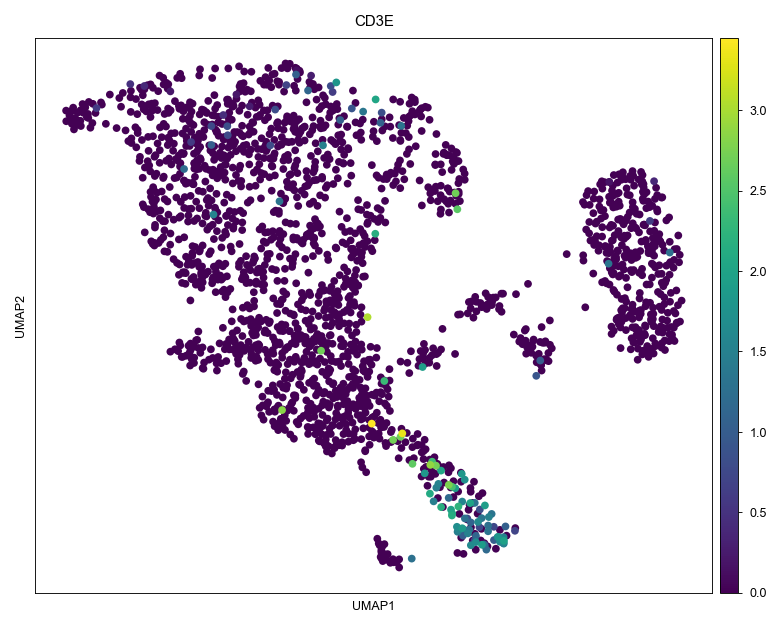

In [23]:
sc.pl.umap(bdata, color='CD3E')

In [26]:
bdata.X = adata_raw[adata.obs.index, :].layers['counts']

In [27]:
bdata.X.sum(axis=1)

matrix([[9507.],
        [6196.],
        [ 607.],
        ...,
        [2547.],
        [5027.],
        [1663.]], dtype=float32)

In [28]:
sc.pp.normalize_total(bdata, target_sum=1e4)

In [29]:
sc.pp.log1p(bdata) #the message only appears because uns['log1p'] slot exists

In [30]:
bdata.X.sum(axis=1)

matrix([[3358.006 ],
        [2753.5972],
        [1204.7992],
        ...,
        [2134.0386],
        [2859.1501],
        [2179.339 ]], dtype=float32)

In [31]:
# load intermediates I saved when preparing the SPRING plot
path1 = '/Users/justina/Documents/mokslai/LAB/amniotic_fluid/data and SPRING/' 
project_dir = path1+'AML_full/'
plot_name =  'AML_prec_only_206'


params = rz.load_stuff(project_dir+plot_name+'/params.pickle')
params.keys()

dict_keys(['k', 'cell_mask', 'min_counts', 'min_cells', 'base_ix', 'num_pc', 'plot_name', 'embedding', 'gene_names_excluded', 'abundant_gene_mask', 'v_score_dict', 'nr_var_genes', 'genes_used', 'eigenvectors', 'eigenvalues', 'neighbors', 'min_dist'])

In [37]:
bdata.obsp['connectivities']

<2167x2167 sparse matrix of type '<class 'numpy.float32'>'
	with 57212 stored elements in Compressed Sparse Row format>

In [38]:
G  = bdata.obsp['connectivities']

# Louvain clustering (choose "resolution")

In [60]:
# start a cell grouping dictionary:
cg = {}

# use scanpy's Louvain clustering to get Louvain clusters at various resolution
#using ultra-high values to cluster the doublets
mock = bdata.copy()
for i in [0.1, 0.2, 0.3,  0.5
]:
    l = list(sc.tl.louvain(mock, resolution = i, adjacency = G, copy = True).obs['louvain'])
    cg['louvain_resolution_%.1f'%i] = l
    print(len(set(l)))

3
4
6
8


# Leiden clustering (choose "resolution")

In [61]:

# use scanpy's Louvain clustering to get Louvain clusters at various resolution
#using ultra-high values to cluster the doublets
mock = bdata.copy()
for i in [0.1, 0.2, 0.3, 0.4, 0.5
]:
    l = list(sc.tl.leiden(mock, resolution = i, adjacency = G, copy = True).obs['leiden'])
    cg['leiden_resolution_%.1f'%i] = l
    print(len(set(l)))

4
7
8
9
10


# Spectral clustering (choose number of cluster)

In [62]:
# this one is much slower

for i in [2, 3, 4, 5, 6, 7]:
    key = 'sp_cl_%d'%(i)
    print(key)
    cg[key] = list(srz.spec_clust(G,i).astype(str))
    print(key)

sp_cl_2
sp_cl_2
sp_cl_3
sp_cl_3
sp_cl_4
sp_cl_4
sp_cl_5
sp_cl_5
sp_cl_6
sp_cl_6
sp_cl_7
sp_cl_7


# Append result to the same SPRING plot

In [65]:
# load current color dictionary
cg0 = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')


# color dictionary of dictionaries
cdd = {key:value['label_colors'] for key,value in cg0.items()}


In [67]:
cg = {key:list(np.array(value).astype(str)) for key,value in cg.items()}

In [68]:
# append categorical colortrack
srz.append_cell_groupings(project_dir+plot_name,cg,colordd=cdd)

In [69]:
for key, value in cg.items():
    adata.obs[key] = cg[key]

In [70]:
obs = adata.obs

In [74]:
#save obs with clusters

fname = 'backups/%s_clust__obs_info_%dx%d_%s'%(plot_name, obs.shape[0],obs.shape[1],rz.now())
print(fname)
rz.save_df(obs,fname)

backups/AML_prec_only_206_clust__obs_info_2167x68_250123_16h50
